# Final Project A2C

Original code wrote by:
Joseph Distefano(jpdistef@buffalo.edu)


In [27]:
# !pip install torch
# !pip install numpy
# !pip install matplotlib
# !pip install gym
# !pip install random 
# !pip install time
# !pip install box2d-py

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
import time
import math


import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from collections import deque, namedtuple

# from keras.models import Sequential
# from keras.layers import *
# from keras.optimizers import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import rc, animation
from IPython import display
from IPython.display import HTML
%matplotlib inline


In [29]:
class A2Cmodel(nn.Module):
    def __init__(self,state_size,action_size,actor = False,critic = False):
        super().__init__()
        self.linear1 = nn.Linear(state_size,64)
        self.linear2 = nn.Linear(64,32)
        
        if actor:
            self.actor = nn.Linear(32,action_size)
            self.softmax = nn.Softmax()
        if critic:
            self.critic = nn.Linear(32,1)
        
    def forward(self,state,actor = False,critic = False):
        out = self.linear1(state)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        
        if actor:
            actorx = self.actor(out)
            actorx = self.softmax(actorx)
            return actorx
        if critic:
            criticx =self.critic(out)
            return criticx
        

In [30]:
class A2Cagent():
    def __init__(self,state_size,action_size,lr):
        self.actor = A2Cmodel(state_size,action_size,actor =True,critic = False) 
        self.critic = A2Cmodel(state_size,action_size,actor =False,critic = True) 
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=lr)
        
    def get_action(self,state):
        
        probs = self.actor(t(state),actor =True,critic = False)
        dist = torch.distributions.Categorical(probs=probs)
        action = dist.sample()
        return action,dist
    
    def update(self,advantage,action,dist):
        critic_loss = advantage.pow(2).mean()
        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

        actor_loss = -dist.log_prob(action)*advantage.detach()
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

    def get_advantage(self,reward,done,gamma,next_state,state):
        advantage = reward + (1-done)*gamma*self.critic(t(next_state),actor=False,critic=True) - self.critic(t(state),actor=False,critic=True)
        return advantage

In [31]:
def t(x): return torch.from_numpy(np.asarray(x)).float()

In [32]:
env = gym.make("CartPole-v1")
env.reset()
# plt.imshow(env.render('rgb_array'))

state_size = env.observation_space.shape[0]
action_size = env.action_space.n


In [23]:
env = gym.make('LunarLander-v2')
env.reset()
# plt.imshow(env.render('rgb_array'))
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [33]:
num_episodes = 500
lr = 0.001
agent = A2Cagent(state_size,action_size,lr)
gamma = 0.99

episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action,dist = agent.get_action(state)
        next_state, reward, done, info = env.step(action.detach().data.numpy())

        advantage = agent.get_advantage(reward,done,gamma,next_state,state)
        
        total_reward += reward
        state = next_state
        agent.update(advantage,action,dist)

        if done: 
            break
    
    episode_rewards.append(total_reward)
    
    if episode % 100 == 0:
        
        print('Episode {}'.format(episode))
        print('Last Episode Reward: {}'.format(total_reward))
        print('-'*10)



/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode 0
Last Episode Reward: 12.0
----------
Episode 100
Last Episode Reward: 41.0
----------
Episode 200
Last Episode Reward: 500.0
----------
Episode 300
Last Episode Reward: 179.0
----------
Episode 400
Last Episode Reward: 147.0
----------


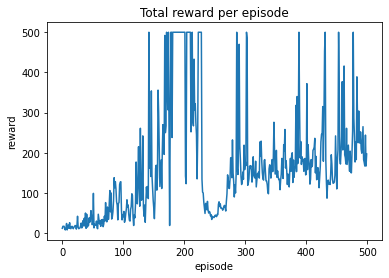

In [34]:
plt.plot(episode_rewards)
plt.title("Total reward per episode")
plt.ylabel("reward")
plt.xlabel("episode")
plt.show()

In [35]:
np.save('A2C_cartpole',episode_rewards)